In [18]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Minimum Variance Portfolio Backtest.

In [19]:
import pandas as pd
from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from qamsi.features.preprocessor import Preprocessor
from run import Dataset

In [20]:
REBAL_FREQ = "ME"
DATASET = Dataset.SPX_US
ESTIMATION_WINDOW = 365 * 1

In [21]:
experiment_config = DATASET.value()

stocks = tuple(
    pd.read_csv(experiment_config.PATH_OUTPUT / experiment_config.STOCKS_LIST_FILENAME)
    .iloc[:, 0]
    .astype(str)
    .tolist(),
)
experiment_config.ASSET_UNIVERSE = stocks  # type: ignore  # noqa: PGH003

experiment_config.MIN_ROLLING_PERIODS = ESTIMATION_WINDOW + 1
experiment_config.N_LOOKBEHIND_PERIODS = None
experiment_config.REBALANCE_FREQ = REBAL_FREQ

experiment_config.START_DATE = experiment_config.START_DATE + pd.Timedelta(days=30 * 95)

factors = pd.read_csv(experiment_config.PATH_OUTPUT / "factors.csv")
factors["date"] = pd.to_datetime(factors["date"])
factors = factors.set_index("date")
factor_names = tuple(factors.columns.astype(str).tolist())
experiment_config.FACTORS = factor_names

prices = [stock + "_Price" for stock in list(stocks)]
preprocessor = Preprocessor(
    exclude_names=[
        *list(stocks),
        experiment_config.RF_NAME,
        *experiment_config.HEDGING_ASSETS,
        *factor_names,
        *prices,
    ],
)

trading_config = TradingConfig(
    broker_fee=0.05 / 100,
    bid_ask_spread=0.03 / 100,
    total_exposure=1,
    max_exposure=1,
    min_exposure=0,
    trading_lag_days=1,
)

runner = Runner(
    experiment_config=experiment_config,
    trading_config=trading_config,
    verbose=True,
)

Backtest on 2007-11-28 00:00:00 to 2023-12-29 00:00:00


In [22]:
ESTIMATOR = CovEstimators.DNK.value(shrinkage_type="linear")

strategy = MinVariance(
    cov_estimator=ESTIMATOR,
    trading_config=trading_config,
    window_size=ESTIMATION_WINDOW,
)

strategy_name = ESTIMATOR.__class__.__name__

result = runner(
    feature_processor=preprocessor,
    strategy=strategy,
    hedger=None,
)
result

Num Train Iterations: 176


Computing Weights: 100%|██████████| 176/176 [00:24<00:00,  7.23it/s]


StrategyStatistics:
* final_nav = 3.503090
* geom_avg_total_r = 0.112367
* geom_avg_xs_r = 0.081975
* std_xs_r = 0.134682
* min_xs_r = -0.090029
* max_xs_r = 0.087031
* skew = -0.599049
* kurtosis = 24.665290
* max_dd = -0.305391
* sharpe = 0.608660
* alpha_buy_hold = -0.039077
* tracking_error_buy_hold = 0.123102
* ir_buy_hold = -0.317438
* factor_loadings = {'low_risk': 0.46464367287660646, 'momentum': -0.016361347832701552, 'quality': -0.10845470247886353, 'size': 0.07825398281893337, 'value': -0.09720541374426264, 'spx': 0.6867634659578524}
* alpha_benchmark = -0.004807
* alpha_benchmark_pvalue = 0.947324
* tracking_error_benchmark = 0.075328
* ir_benchmark = -0.063813
* ttest_pval = 0.740366
* levene_pval = 0.000000
* timing_ability_coef = -0.053534
* timing_ability_pval = 0.005156

In [23]:
result.std_xs_r

np.float64(0.13468152087187207)

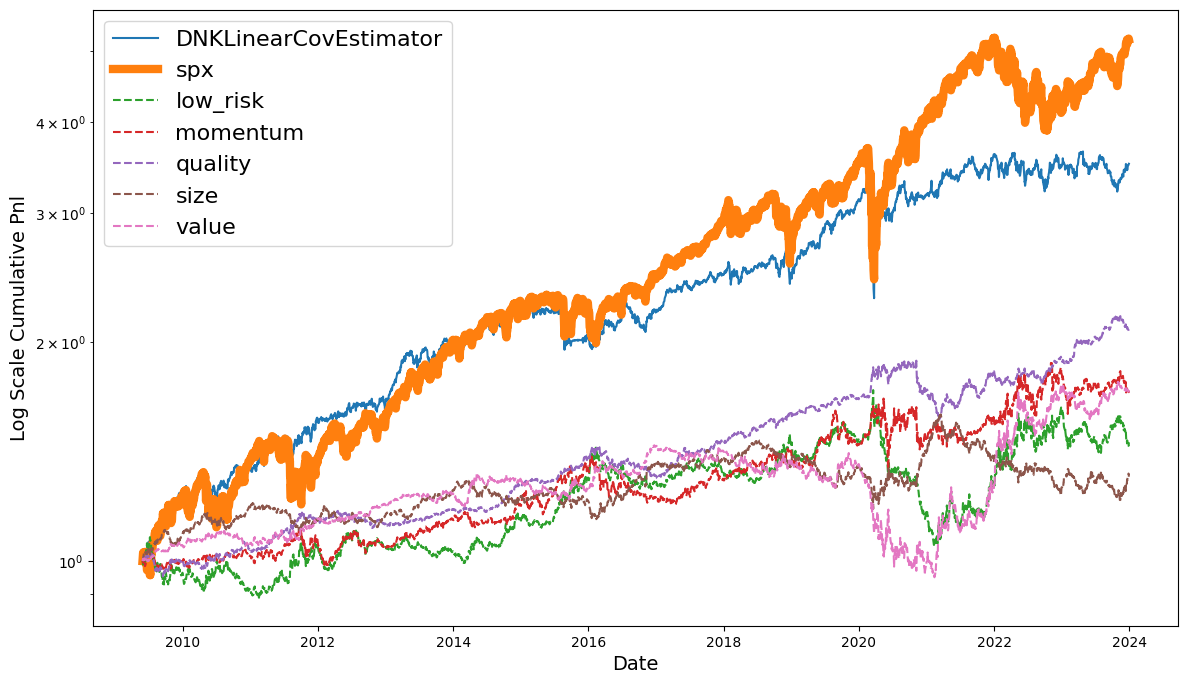

In [24]:
runner.plot_cumulative(
    strategy_name=strategy_name,
    include_factors=True,
)

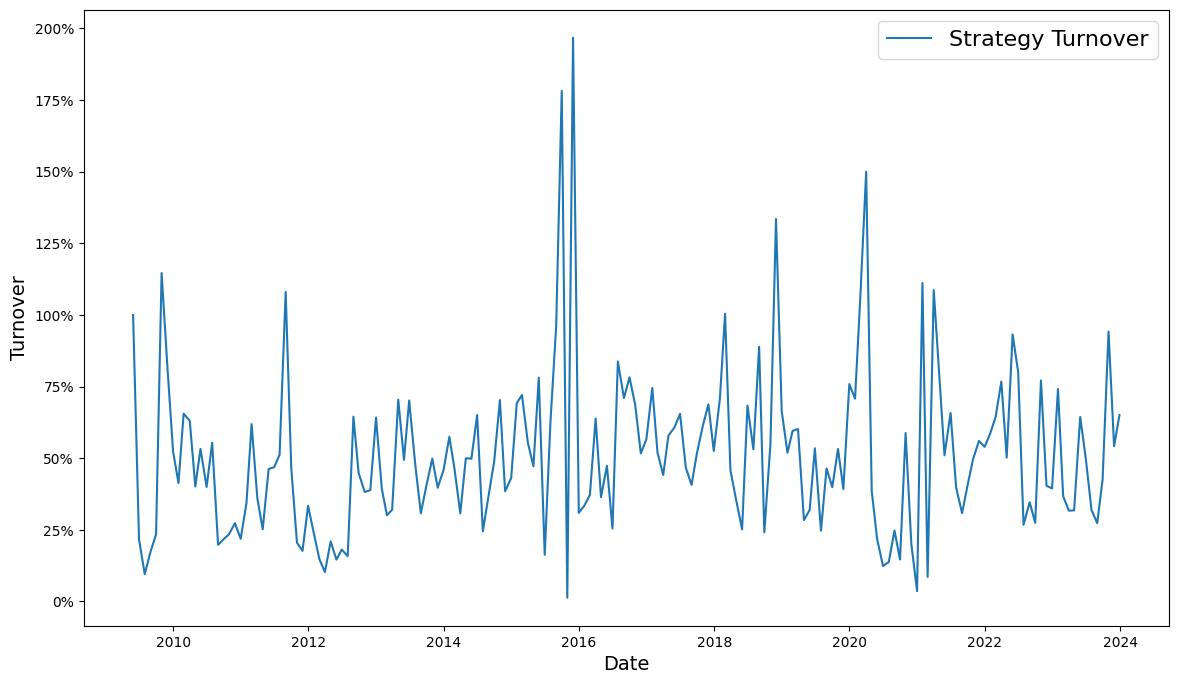

In [25]:
runner.plot_turnover()

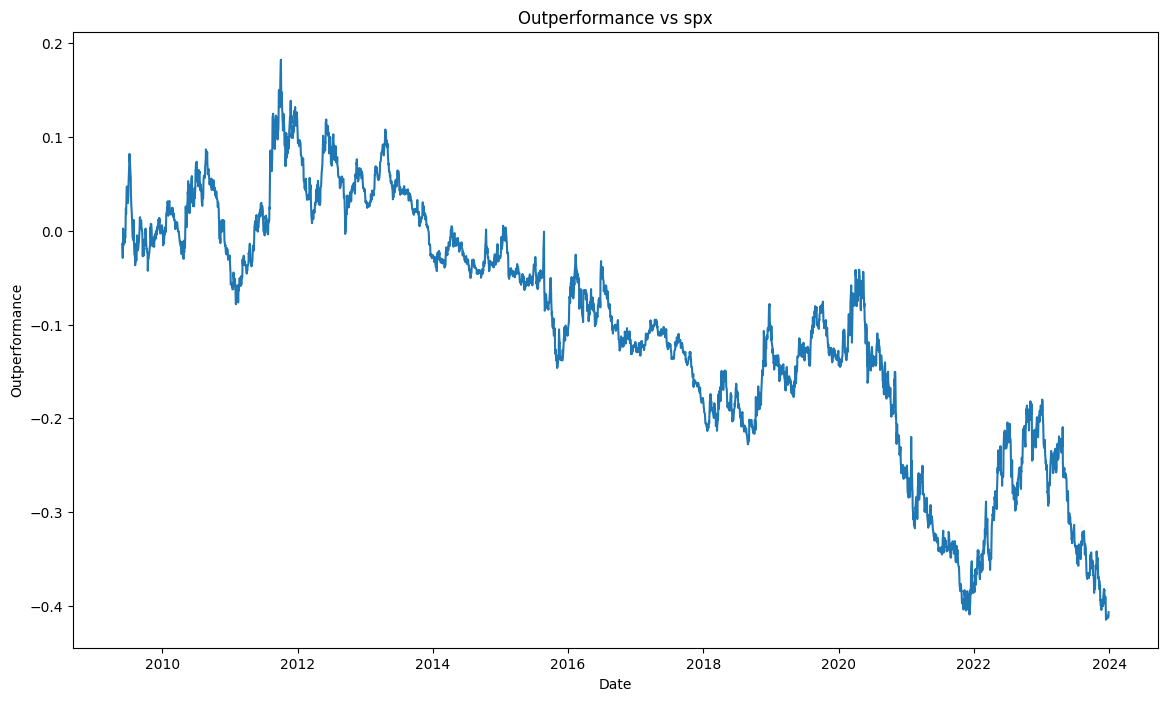

In [26]:
runner.plot_outperformance(mkt_only=True)

In [27]:
runner.save(DATASET.name + strategy_name + f"_rebal{REBAL_FREQ}")